In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model/config.json
/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model/tokenizer_config.json
/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model/model.safetensors
/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model/special_tokens_map.json
/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model/vocab.txt
/kaggle/input/twitter-hate-speech/train_E6oV3lV.csv
/kaggle/input/twitter-hate-speech/test_tweets_anuFYb8.csv


In [2]:
df_test = pd.read_csv("/kaggle/input/twitter-hate-speech/test_tweets_anuFYb8.csv")

In [3]:
df_test.shape

(17197, 2)

In [4]:
import emoji
def emoji_text_trans(text):
    text= emoji.demojize(text).replace (':', ' ')

    #delete repeated emoji 
    tokenize= text.split()
    repeated_list=[]
    for word in tokenize:
        if word not in repeated_list:
            repeated_list.append(word)

    text=' '.join(word for word in repeated_list)
    text= text.replace("_", " ").replace("-", " ")
    return text

In [5]:
#Repeated char function 
def repeated_char(text):
  text = re.sub(r'(\w)\1{2,}',r'\1',text)
  return text

In [6]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text) # remove URLs
    text = re.sub(r"@\w+", "", text) #remove mentions
    text = re.sub(r"#\w+", "", text) #remove hashtags
    #text = re.sub(r"[^\w\s]", "", text) #remove special characters
    return text.lower().strip()

In [7]:
def contains_invalid_encoding(text):
    if isinstance(text, str):
        return bool(re.search(r'[^\x00-\x7F]+', text))  
    return False  

In [8]:
def decode_text(text):
    try:
        #Handling the characters's error
        return text.encode('latin1').decode('utf-8', errors='ignore')
    except UnicodeDecodeError:
        return text

In [9]:
import re
df_test['cleaned_tweet']= df_test['tweet'].apply(clean_text)
df_test['cleaned_tweet'] = df_test['cleaned_tweet'].astype(str)
df_test['decoded_tweet'] = df_test['cleaned_tweet'].apply(lambda x: decode_text(x) if contains_invalid_encoding(x) else x)
df_test['clean_duplicate']=df_test['decoded_tweet'].apply(repeated_char)
df_test["deemoji_tweet"] = df_test["clean_duplicate"].apply(emoji_text_trans)

In [10]:
df_test

,id,tweet,cleaned_tweet,decoded_tweet,clean_duplicate,deemoji_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,to find ¦,to find,to find,to find
1,31964,@user #white #supremacists want everyone to s...,want everyone to see the new â  â and ...,want everyone to see the new ‘ — and here’s...,want everyone to see the new ‘ — and here’s...,want everyone to see the new ‘ — and here’s why
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your !! !!,safe ways to heal your !! !!,safe ways to heal your !! !!,safe ways to heal your !!
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and cursed child book up for reserva...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncle ..."
...,...,...,...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factory: left-right polarisation! ...,thought factory: left-right polarisation! ...,thought factory: left-right polarisation! ...,thought factory left right polarisation! &gt;3
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid ð â¦,feeling like a mermaid 😘 …,feeling like a mermaid 😘 …,feeling like a mermaid face blowing a kiss …
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,"today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets..."
17195,49158,"happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference right mindset leads ..."


In [11]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Recall previous trained model (in this case, the distillBERT_(ver2))
model_path = '/kaggle/input/distilbert_model/pytorch/default/1/distilbert_model'

tokenizer = DistilBertTokenizer.from_pretrained(model_path, local_files_only=True)
model = DistilBertForSequenceClassification.from_pretrained(model_path, local_files_only=True)

model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [12]:
# Tokenize tweets
texts = df_test['deemoji_tweet'].tolist()

encoded_inputs = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1) 

predicted_labels = predictions.cpu().numpy()

df_test['predicted_labels'] = predicted_labels

print(df_test[['deemoji_tweet', 'predicted_labels']])

                                           deemoji_tweet  predicted_labels
0                                                to find                 0
1        want everyone to see the new ‘ — and here’s why                 0
2                              safe ways to heal your !!                 0
3      is the hp and cursed child book up for reserva...                 0
4      3rd to my amazing, hilarious eli ahmir! uncle ...                 0
...                                                  ...               ...
17192     thought factory left right polarisation! &gt;3                 1
17193       feeling like a mermaid face blowing a kiss …                 0
17194  today in ((omg)) &amp; used words like "assets...                 0
17195  happy, at work conference right mindset leads ...                 0
17196                   my song "so glad" free download!                 0

[17197 rows x 2 columns]


In [13]:
df_test[['deemoji_tweet', 'predicted_labels']]

,deemoji_tweet,predicted_labels
0,to find,0
1,want everyone to see the new ‘ — and here’s why,0
2,safe ways to heal your !!,0
3,is the hp and cursed child book up for reserva...,0
4,"3rd to my amazing, hilarious eli ahmir! uncle ...",0
...,...,...
17192,thought factory left right polarisation! &gt;3,1
17193,feeling like a mermaid face blowing a kiss …,0
17194,"today in ((omg)) &amp; used words like ""assets...",0
17195,"happy, at work conference right mindset leads ...",0


In [14]:
df_test

,id,tweet,cleaned_tweet,decoded_tweet,clean_duplicate,deemoji_tweet,predicted_labels
0,31963,#studiolife #aislife #requires #passion #dedic...,to find ¦,to find,to find,to find,0
1,31964,@user #white #supremacists want everyone to s...,want everyone to see the new â  â and ...,want everyone to see the new ‘ — and here’s...,want everyone to see the new ‘ — and here’s...,want everyone to see the new ‘ — and here’s why,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your !! !!,safe ways to heal your !! !!,safe ways to heal your !! !!,safe ways to heal your !!,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,is the hp and cursed child book up for reserva...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncl...","3rd to my amazing, hilarious eli ahmir! uncle ...",0
...,...,...,...,...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factory: left-right polarisation! ...,thought factory: left-right polarisation! ...,thought factory: left-right polarisation! ...,thought factory left right polarisation! &gt;3,1
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid ð â¦,feeling like a mermaid 😘 …,feeling like a mermaid 😘 …,feeling like a mermaid face blowing a kiss …,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,"today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets...","today in ((omg)) &amp; used words like ""assets...",0
17195,49158,"happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...","happy, at work conference right mindset leads ...",0


In [16]:
import pandas as pd
df_test.to_csv('/kaggle/working/predict_df.csv', index=False)  


In [23]:
df_test[df_test["predicted_labels"]==1][["deemoji_tweet","predicted_labels"]]

,deemoji_tweet,predicted_labels
19,thought factory bbc neutrality on right wing f...,1
26,chick gets fucked hottest naked lady,1
33,suppo the fisherman! no bullying! racism!,1
34,i say we because i'm speaking collectively. i'...,1
42,trumps invested billions into saudi. he empowe...,1
...,...,...
17125,be careful in criticizing for his decision on ...,1
17128,the uk government’s new semitism definition c...,1
17176,are the most racist pay ever!!!!!,1
17188,"black professor demonizes, proposes nazi style...",1


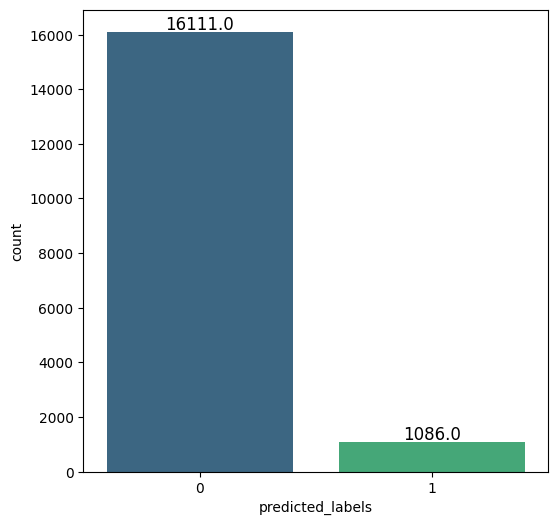

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df_test, x="predicted_labels", palette='viridis')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),  # Adjust text position (optional)
                textcoords='offset points')

# Show the plot
plt.show()